In [4]:
import pickle

with open(f'./data/openai_gpt_final_results.pkl', 'rb') as infile:
    results = pickle.load(infile)

In [7]:
import seaborn as sns
import pandas as pd
import numpy as np

negent = -1*np.array(results["entropy"])
ent_correct = np.array(results["entropy_correct"]).astype(np.float32)

negdent = -1*np.array(results["dentropy"])
dent_correct = np.array(results["dentropy_correct"]).astype(np.float32)

neg_og_ent = -1*np.array(results["og_entropy"])
og_ent_correct = np.array(results["og_entropy_correct"]).astype(np.float32)

negperp = -1*np.array(results["perplexity"])
perp_correct = np.array(results["perplexity_correct"]).astype(np.float32)

df = pd.DataFrame({
    'SE':negent, 
    'SE_correct':ent_correct, 
    'DSE':negdent, 
    'DSE_correct':dent_correct, 
    'OSE':neg_og_ent, 
    'OSE_correct':og_ent_correct, 
    'Perplexity':negperp, 
    'Perp_correct':perp_correct, 
    })
df

,SE,SE_correct,DSE,DSE_correct,OSE,OSE_correct,Perplexity,Perp_correct
0,0.000000e+00,1.0,0.000000e+00,1.0,1.285671,1.0,-1.004203,1.0
1,0.000000e+00,1.0,0.000000e+00,1.0,1.293095,1.0,-1.005363,1.0
2,-1.110223e-16,1.0,-1.110223e-16,1.0,1.250752,1.0,-1.008647,1.0
3,-1.054633e+00,0.0,-1.054633e+00,0.0,-3.532941,0.0,-1.039408,0.0
4,0.000000e+00,1.0,0.000000e+00,1.0,1.302516,1.0,-1.000036,1.0
...,...,...,...,...,...,...,...,...
1819,2.220446e-16,0.0,2.220446e-16,0.0,0.175143,0.0,-1.094265,0.0
1820,-6.274902e-01,0.0,-6.274902e-01,0.0,-1.567728,0.0,-1.068390,0.0
1821,-6.092301e-01,1.0,-6.092301e-01,1.0,-2.366093,1.0,-1.177898,1.0
1822,0.000000e+00,0.0,0.000000e+00,0.0,0.135097,0.0,-1.150496,0.0


Text(0.5, 1.0, 'Perplexity')

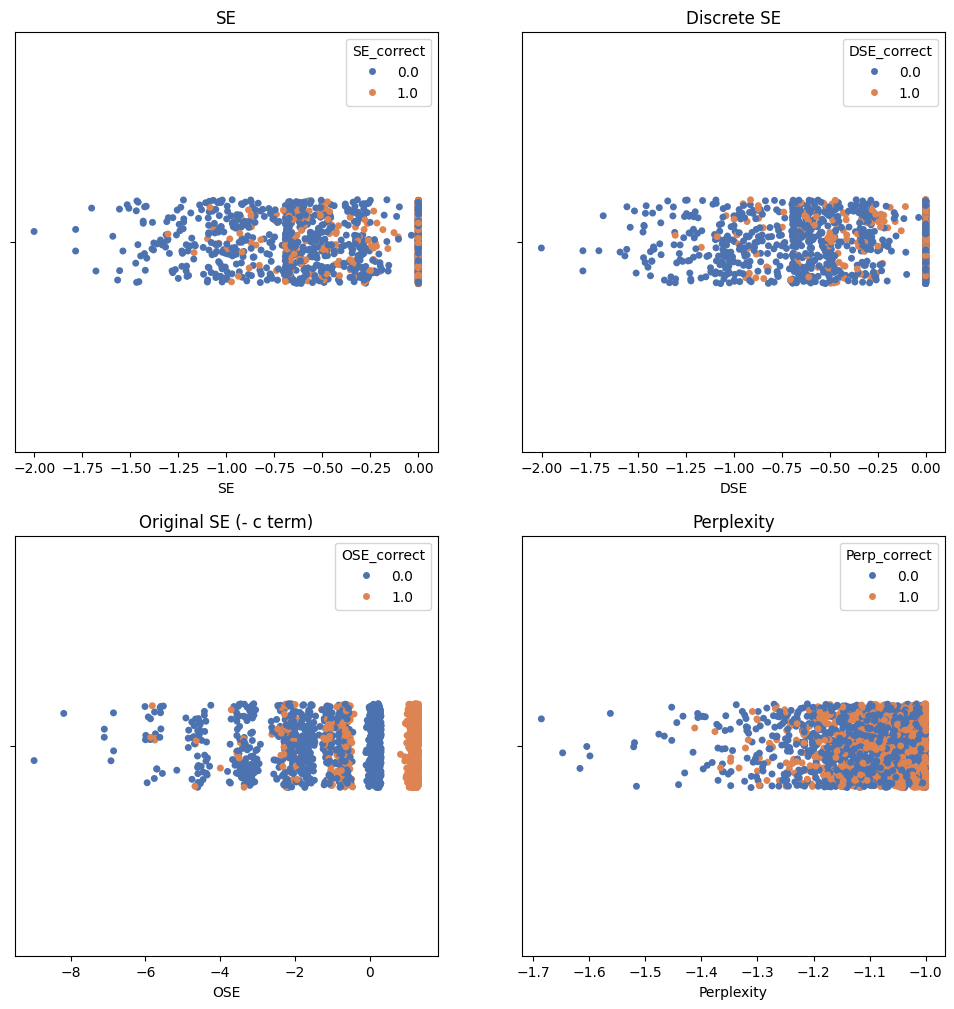

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
sns.stripplot(data=df, x="SE", hue="SE_correct", palette="deep", ax=axes[0,0])
axes[0,0].set_title("SE")
sns.stripplot(data=df, x="DSE", hue="DSE_correct", palette="deep", ax=axes[0,1])
axes[0,1].set_title("Discrete SE")
sns.stripplot(data=df, x="OSE", hue="OSE_correct", palette="deep", ax=axes[1,0])
axes[1,0].set_title("Original SE (- c term)")
sns.stripplot(data=df, x="Perplexity", hue="Perp_correct", palette="deep", ax=axes[1,1])
axes[1,1].set_title("Perplexity")